In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from utils import *
from tests import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Logistic regression

## a9a

In [2]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness const: ", L)
print("Average smoothness const: ", average_L)
print("Worst smoothness const: ", worst_L)
print("Percentage of non-zeros: ", sparsity_A)

Number of functions:  32561 , dimension:  123
Smoothness const:  1.5719196992226587
Average smoothness const:  3.467276803535652
Worst smoothness const:  3.5
Percentage of non-zeros:  0.11275696922074716
Wall time: 216 ms


### Find the solution (Run this code only once)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [ ]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-18)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

In [ ]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

### Noise distribution

In [ ]:
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

In [ ]:
norm(logreg_grad(x_star, [denseA, y, 0, False]))

In [ ]:
%%time
x = deepcopy(x_star)
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

In [ ]:
np.sort(grad_deviations)

In [ ]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean((grad_deviations - mu)**2))
print(mu)
print(sigma)

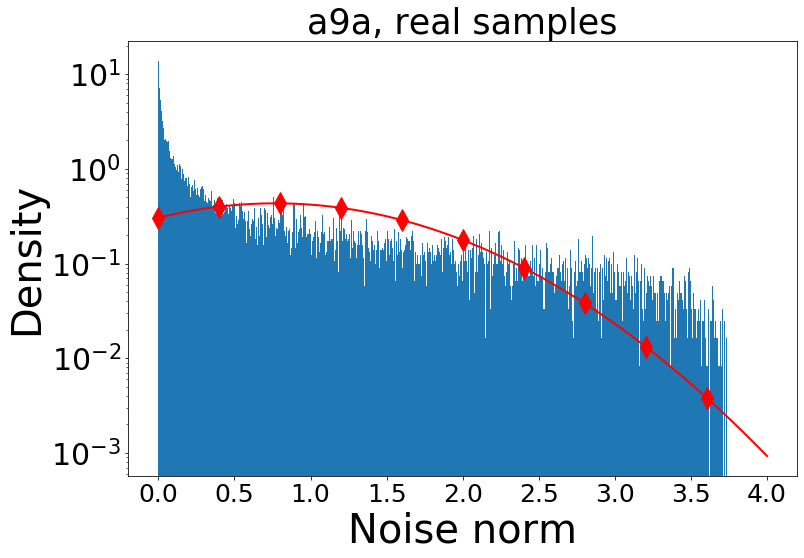

In [74]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=25)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=1000, density=1, log=True)
temp2 = np.linspace(0, 4.0, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_real.pdf", bbox_inches='tight')

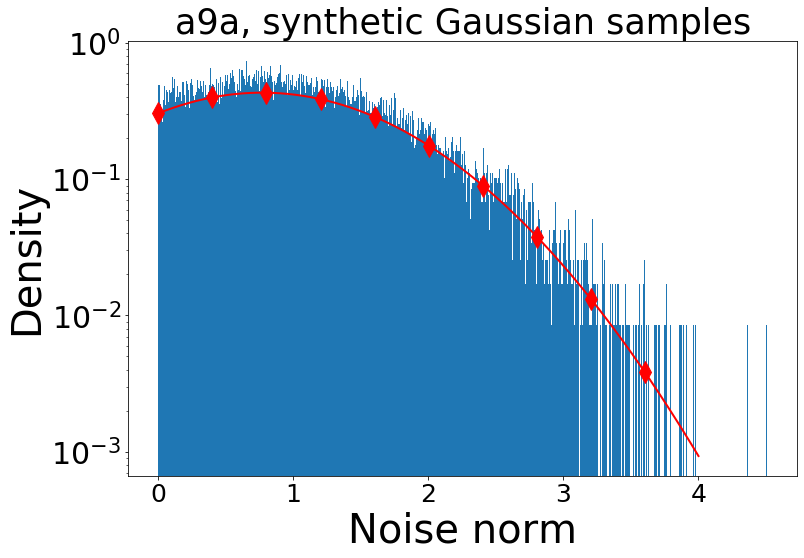

In [75]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=25)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=1000, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
# t, bins, patches = plt.hist(np.where(sample>0, sample, 0), bins=50, density=1, log=True)
temp2 = np.linspace(0, 4.0, 1000)
# plt.plot(temp2, norm_d.pdf(temp2, mu, sigma))
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_synthetic.pdf", bbox_inches='tight')

### Tests

In [3]:
shift_param = 1.0
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = 0
l1 = 0
batch_size = 100
gamma = 1.0/(L+l2)
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)
lambd = 2*np.sqrt(2)*(L+l2)*norm(x_star-x_init)
lambd_schedule = [lambd, 1000, 0.9]
S = 100
save_info_period = 100
beta = 0.001
N = int(S*m/batch_size)
a = ((np.log(4*N/beta)) ** 2)
print("a = ", a)

B = norm(x_star-x_init) / (np.log(4*N/beta))
print("B = ", B)

sparse_full = False
sparse_stoch = False

a =  349.12624184438624
B =  0.5935554663414726


In [4]:
print("gamma = ", gamma)

gamma =  0.6361648120413003


In [5]:
print("Functional suboptimality: ", logreg_loss(x_init, [denseA,y,l2,False,0])-f_star)

Functional suboptimality:  7.729129353580209


In [6]:
print(lambd)

49.30919423547079


### SSTM

In [ ]:
%%time

res = sstm(filename=filename, x_init=x_init, A=A, y=y, a=1.0,
             L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)

In [ ]:
%%time

res = clipped_sstm(filename=filename, x_init=x_init, A=A, y=y, a=1.0,
             B=B*B_tun_const, L=L+l2, l2=l2, 
             sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
             S=S, max_t=np.inf,
             batch_size=batch_size, indices=None, save_info_period=save_info_period, 
             x_star=x_star, f_star=f_star)
        i += 1
        print("Комбинация ", i)
        print(a_tun_const, B_tun_const)
        print("Найденное значение: ", res['func_vals'][-1]+f_star)

### SGD and clipped-SGD

In [ ]:
%%time
lambd_schedule = [lambd*0.1, 5, 0.5]
res = clipped_sgd_const_stepsize_decr_clip(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     lambd_schedule=lambd_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
res = clipped_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma*0.5,
     lambd=lambd*0.0005, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma*0.5,
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

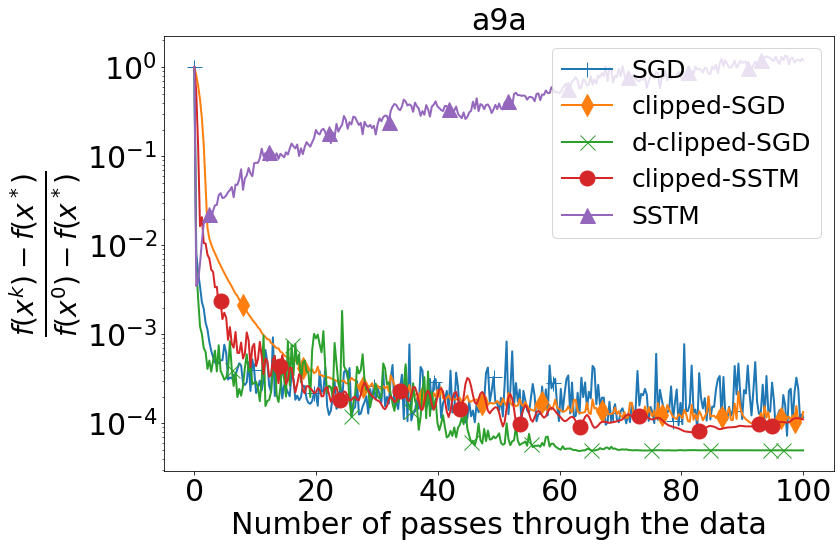

In [68]:
methods = [
         ['SGD_const_stepsize', [gamma*0.5, l2, l1, S, batch_size], 
           'SGD', None],
         ['clipped-SGD_const_stepsize', [gamma*0.5, lambd*0.0005, l2, l1, S, batch_size], 
           'clipped-SGD', None],
         ['clipped-SGD_const_stepsize_decr_clip', [gamma, 
                                                   lambd_schedule,
                                                   l2, l1, S, batch_size], 
           'd-clipped-SGD', None],
           ['clipped-SSTM', [1.0, B*0.05, L+l2, l2, S, batch_size], 
           'clipped-SSTM', None],
         ['SSTM', [1.0, L+l2, l2, S, batch_size], 
           'SSTM', None],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 25
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, filename+"_test_test.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [ ]:
res = read_results_from_file(filename, 'SGD_const_stepsize', [gamma, l2, l1, S, batch_size])

In [ ]:
%%time
x = deepcopy(res['last_iter'])
grad_deviations = np.array([])
full_grad = logreg_grad(x, [denseA,y,0,False])
for i in range(m):
    grad_deviations = np.append(grad_deviations, np.linalg.norm(logreg_grad(x, [denseA[[i]],y[[i]],0,False]) - full_grad))

In [ ]:
print(norm(full_grad))

In [ ]:
mu = np.mean(grad_deviations)
sigma = np.sqrt(np.mean((grad_deviations - mu)**2))
print(mu)
print(sigma)

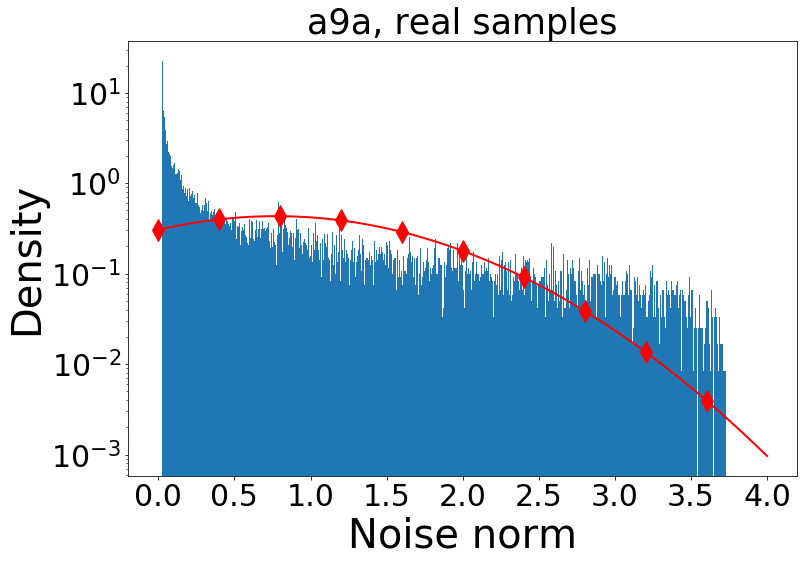

In [63]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
t, bins, patches = plt.hist(np.sort(grad_deviations), bins=1000, density=1, log=True)
temp2 = np.linspace(0, 4, 1000)
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, real samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_sgd_last_point_big_step.pdf", bbox_inches='tight')

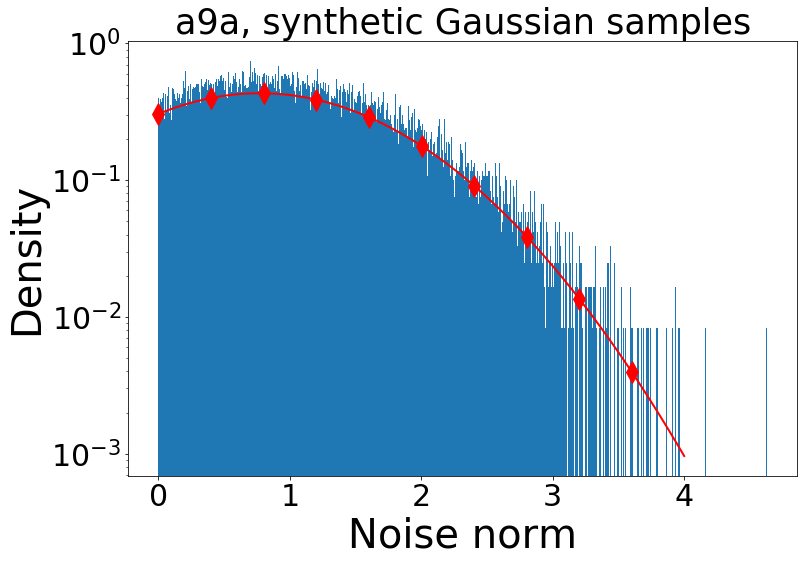

In [64]:
plt.figure(figsize=(12,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
sample = norm_d.rvs(loc=mu, scale=sigma, size=m)
sample = sample[sample > 0]
t, bins, patches = plt.hist(sample, bins=1000, density=(1 - norm_d.cdf(0,loc=mu,scale=sigma)), log=True)
# t, bins, patches = plt.hist(np.where(sample>0, sample, 0), bins=50, density=1, log=True)
temp2 = np.linspace(0, 4, 1000)
# plt.plot(temp2, norm_d.pdf(temp2, mu, sigma))
plt.semilogy(temp2, norm_d.pdf(temp2, mu, sigma), linewidth=2, color='red', marker='d',
            markersize = 15, 
            markevery=range(0, 1000, 100))
plt.title('a9a, synthetic Gaussian samples', fontsize=35)
plt.xlabel("Noise norm", fontsize=40)
plt.ylabel("Density", fontsize=40)
plt.savefig("plot/a9a_synthetic_sgd_last_iter_big_step.pdf", bbox_inches='tight')